# Apply Generative Perturbations

This notebook demonstrates how to apply generative perturbations using diffusion models. Generative perturbers use pre-trained deep learning models to synthesize realistic modifications to images based on text prompts.

We use a sample image from the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset to demonstrate diffusion-based perturbations.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/generative_perturbers.ipynb)

## Set Up the Environment

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

This notebook requires NRTK with the following extra: `diffusion`

- `diffusion` - Diffusion model dependencies for AI-powered generative perturbations

**Note**: The first time you run a diffusion perturber, it will download a pre-trained model (several gigabytes). Using a GPU is strongly recommended for performance.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
%pip install -qU pip
print("Installing nrtk with required extras...")
try:
    import diffusers  # noqa: F401 -- intentionally unused, just checking availability

    import nrtk  # noqa: F401 -- intentionally unused, just checking availability
except ImportError:
    %pip install -q "nrtk[diffusion]"
    pass  # jupytext converts %pip to a comment, so pass keeps the block valid
print("Installing matplotlib...")
%pip install -q matplotlib
print("Done!")

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import os
import urllib.request

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from nrtk.impls.perturb_image.generative import DiffusionPerturber

device = "cuda"

## Select Initial Image

We'll carry out perturbations on a single image from VisDrone

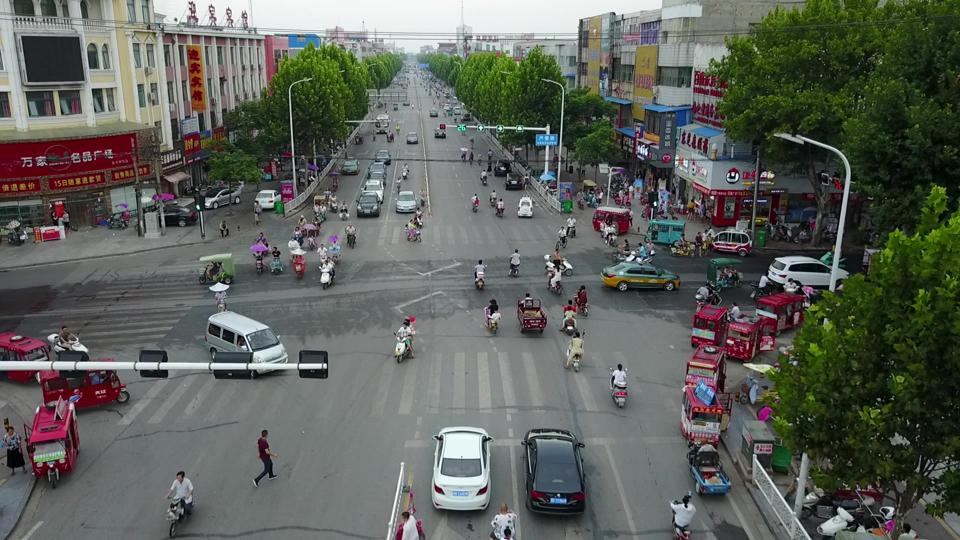

In [5]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    print("Downloading image...")
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

# Load image with PIL
img_pil = Image.open(img_path)

img_pil

## Resize Image

The diffusion perturber expects a resized image, so we will resize the image

Original image size: (960, 540)
Resized image size: (456, 256)


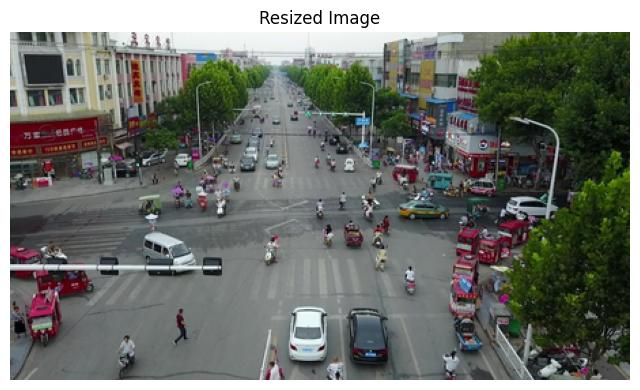

In [4]:
def resize_image_for_diffusion(img_to_resize: Image.Image) -> Image.Image:
    """Resize image using the same logic as DiffusionPerturber._resize_image."""
    original_w, original_h = img_to_resize.size
    min_dimension = 256

    # Scale image down to the minimum dimension
    scale = min_dimension / min(original_w, original_h)
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)

    # Round to the nearest multiple of 8 (required by the diffusion model)
    new_w = round(new_w / 8) * 8
    new_h = round(new_h / 8) * 8

    # Lanczos resampling improves image quality
    return img_to_resize.resize((new_w, new_h), Image.Resampling.LANCZOS)


# Resize the loaded image
img_pil_resized = resize_image_for_diffusion(img_pil)

print(f"Original image size: {img_pil.size}")
print(f"Resized image size: {img_pil_resized.size}")

img_resized_rgb = np.asarray(img_pil_resized)

# Display the resized image
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Resized Image")
_ = plt.imshow(img_resized_rgb)
plt.show()

## NRTK Diffusion Perturbation: Examples and Guidance

The `DiffusionPerturber` uses powerful, pre-trained diffusion models to apply complex, realistic perturbations based on text prompts. By default, it uses a model from the `Instruct-Pix2Pix` family, which excels at editing images based on text instructions.

The perturber is configured by the following key parameters:

-   `prompt`: A natural language description of the desired change. This is the most important parameter for controlling the visual output. Examples include *"add heavy rain"*, *"make it look like a winter scene"*, or *"change the time to night"*.
-   `model_name`: The specific pre-trained model to use from the Hugging Face Hub. The default is `"timbrooks/instruct-pix2pix"`.
-   `seed`: An integer to ensure that the "random" aspects of the diffusion process are reproducible.
-   `num_inference_steps`: The number of denoising steps in the diffusion process. Higher values can lead to higher quality results but increase computation time. Default is 50.
-   `text_guidance_scale`: Controls how much the model's output is influenced by the text prompt. Higher values mean the model adheres more strictly to the prompt. Default is 8.0.
-   `image_guidance_scale`: Controls how much the model's output preserves the structure of the original input image. Higher values mean more of the original image is retained. Default is 2.0.
-   `device`: Specifies the computation device (`"cuda"` or `"cpu"`). Using `"cuda"` is strongly recommended for performance. If not specified, it will auto-detect a GPU but fall back to CPU if one is not available.

**Important Notes for this Notebook:**

-   **Performance:** Diffusion models are computationally intensive. The first time you use the perturber, it will download the model (which can be several gigabytes). Running on a CPU will be **significantly** slower than on a GPU.
-   **Focus:** For this notebook, we will primarily change the `prompt` to generate different visual effects. We will keep the other parameters at their default values to demonstrate the core functionality.
-   **Image Resizing:** The input image is automatically resized to be compatible with the diffusion model's expected input dimensions. This means the output image from the perturber will have different dimensions than the input image.

### Generated Perturbed Image
This is a helper function that contains logic to generate an perturbed image and plot it.

In [ ]:
def generate_perturbed_image(
    prompt_text: str,
    input_image: np.ndarray,
    seed: int = 42,
    device: str = "cuda",
) -> plt.Figure:
    """Generates a perturbed image based on a text prompt using DiffusionPerturber.

    Args:
        prompt_text (str): The text prompt to guide the perturbation.
        input_image (np.ndarray): The input image to be perturbed.
        seed (int): The random seed for reproducibility.
        device (str): The device to run the model on ('cuda' or 'cpu').

    Returns:
        plt.Figure: The matplotlib figure containing the perturbed image.
    """
    perturber = DiffusionPerturber(prompt=prompt_text, seed=seed, device=device)
    perturbed_img, _ = perturber(image=input_image)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(perturbed_img)
    ax.axis("off")
    ax.set_title(prompt_text)
    return fig

### Add smog to the image

This prompt causes the diffusion model to add smog to the image


Loading pipeline components...:  50%|█████     | 3/6 [00:00<00:00, 23.58it/s]

100%|██████████| 50/50 [00:05<00:00,  9.02it/s]


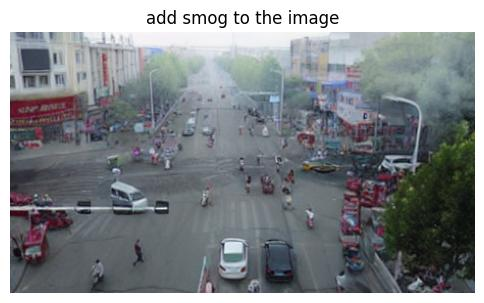

In [6]:
prompt = "add smog to the image"

img1 = generate_perturbed_image(prompt, img_resized_rgb)

### Turn the image into night

This prompt causes the diffusion model to take the daytime image and make it a night scene


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


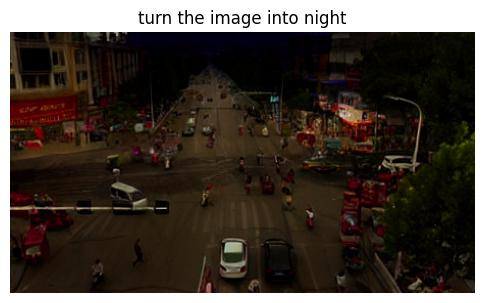

In [7]:
prompt = "turn the image into night"

img2 = generate_perturbed_image(prompt, img_resized_rgb)

### Add snow on the ground

This prompt causes the diffusion model to add a light layer of snow on the ground


100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


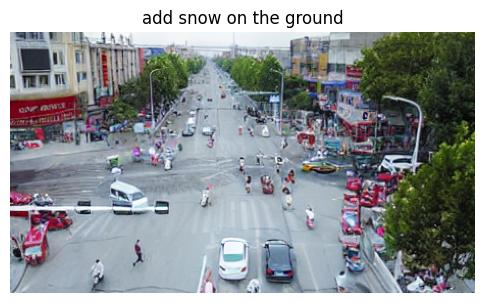

In [8]:
prompt = "add snow on the ground"

img3 = generate_perturbed_image(prompt, img_resized_rgb)